In [ ]:
# %tensorflow_version 1.x

TensorFlow 1.x selected.


# 폐 영역분할

다음의 2019 대한의료인공지능학회 Summer School에서 진행한 AI hands-on의 자료에서 코드르 가져와서 수정함.

https://github.com/mi2rl/ai_handson/blob/master/KoSAIM_Summer_School_2019_Handson_03_Segmentation.ipynb


## 폐 데이터 다운로드

다음에서 다운받은 데이터

https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

In [ ]:
%%shell
rm -rf Lung_Segmentation.zip
wget https://github.com/dhrim/hongik_2021/raw/master/material/deep_learning/Lung_Segmentation.zip

--2020-08-20 23:55:33--  https://github.com/dhrim/hongik_2021/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/hongik_2021/master/material/deep_learning/Lung_Segmentation.zip [following]
--2020-08-20 23:55:34--  https://raw.githubusercontent.com/dhrim/hongik_2021/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M  --.-KB/s    in 0.09s   

2020-08-20 23:55:36 (379 MB/

In [ ]:
%%shell
rm -rf Lung_Segmentation
unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
   creating: Lung_Segmentation/
   creating: Lung_Segmentation/image/
  inflating: Lung_Segmentation/image/CHNCXR_0001_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0002_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0003_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0004_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0005_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0006_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0007_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0008_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0009_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0010_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0011_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0012_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0013_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0014_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0015_0.png  
  inflating: Lung_Segmentation/image/CHNCXR

## 풀린 데이터 파일 구조

```
Lung_segmentaiton/
  image/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
  label/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
```

## 파일 보기

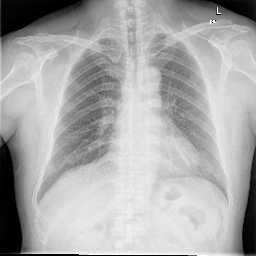

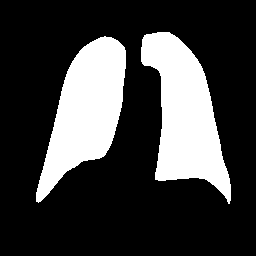

In [1]:
from IPython.display import Image, display

display(Image('data/Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('data/Lung_Segmentation/label/CHNCXR_0001_0.png'))


## 데이터 로딩

In [13]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "data/Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))   # os.listdir() 보충자료 참고
                    # os.path.join(a, b) 인수에 전달된 2개의 문자열을 결합, 1개 경로로 만듬
                    # files는 Lung_Segmentation/image 안에 있는 data 리스트
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]  # os.path.splitext 보충자료 참고
    file_headers.append(f1)

# file_headers = ['CHNCXR_0402_1', 'CHNCXR_0461_1', 'CHNCXR_0422_1', ... ]    
# print(file_headers)

raw_x = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
raw_y = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

count = 0
for fh in file_headers:
    # fh = "CHNCXR_0402_1"

    # f1 = "./Lung_Segmentation/image/CHNCXR_0402_1.png"
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh)) # 이미지데이터를 png 확장자로 변환
    # l1 = "./Lung_Segmentation/label/CHNCXR_0402_1.png"
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))
    
    img = imread(f1)[:,:,:IMG_CHANNELS]  # impread() 이미지를 읽어내는 함수
                                         # https://antilibrary.org/1956
    # img.shape = (256, 256, 3)

    mask = imread(l1)
    # mask.shape = (256, 256)

    mask = np.expand_dims(mask, axis=-1)
    # mask.shape = (256, 256, 1)

    raw_x[count] = img
    raw_y[count] = mask
    
    count += 1


## 원시 데이터 보기

In [3]:
print(raw_x[0])
print(raw_y[0])

[[[58 58 58]
  [22 22 22]
  [ 6  6  6]
  ...
  [22 22 22]
  [31 31 31]
  [37 37 37]]

 [[58 58 58]
  [19 19 19]
  [ 5  5  5]
  ...
  [24 24 24]
  [27 27 27]
  [30 30 30]]

 [[57 57 57]
  [16 16 16]
  [ 4  4  4]
  ...
  [20 20 20]
  [23 23 23]
  [26 26 26]]

 ...

 [[34 34 34]
  [31 31 31]
  [24 24 24]
  ...
  [27 27 27]
  [28 28 28]
  [31 31 31]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [48 48 48]
  [52 52 52]
  [52 52 52]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [75 75 75]
  [73 73 73]
  [81 81 81]]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


## 데이터 정규화

In [3]:
x_all = raw_x.astype('float32') / 255.
y_all = raw_y

## 데이터 나누기

In [4]:
split_index = int(x_all.shape[0]*0.8)
train_x, test_x = x_all[:split_index], x_all[split_index:]
train_y, test_y = y_all[:split_index], y_all[split_index:]

In [5]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(452, 256, 256, 3)
(452, 256, 256, 1)
(114, 256, 256, 3)
(114, 256, 256, 1)


train


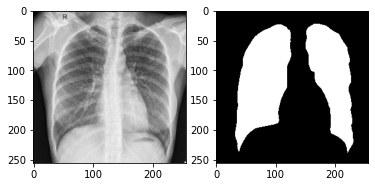

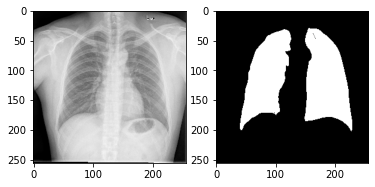

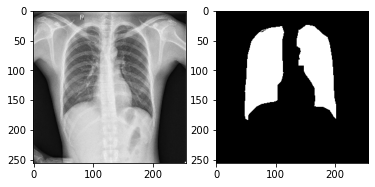

test


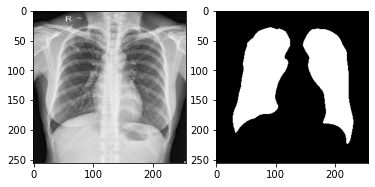

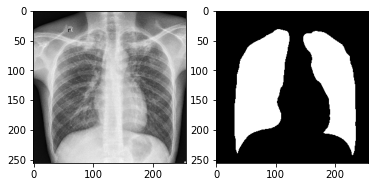

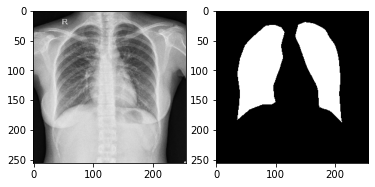

In [6]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))  # randint(시작, 끝-1) 중에서 랜덤 숫자 1개 뽑기
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,256,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## U-Net 모델 정의

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):    # keras
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10]) # 입력은 [inputs], 출력은 [conv10]

## 모델 컴파일과 학습

In [9]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)

# 모델 저장
model.save('unet.h5')


Epoch 1/20
46/46 [==============================] - 23s 302ms/step - loss: 0.2201 - accuracy: 0.6963 - val_loss: 0.2216 - val_accuracy: 0.7198
Epoch 2/20
46/46 [==============================] - 11s 230ms/step - loss: 0.1770 - accuracy: 0.7690 - val_loss: 0.2090 - val_accuracy: 0.7198
Epoch 3/20
46/46 [==============================] - 11s 230ms/step - loss: 0.1527 - accuracy: 0.8065 - val_loss: 0.1998 - val_accuracy: 0.7901
Epoch 4/20
46/46 [==============================] - 11s 231ms/step - loss: 0.1292 - accuracy: 0.8405 - val_loss: 0.1990 - val_accuracy: 0.7650
Epoch 5/20
46/46 [==============================] - 11s 231ms/step - loss: 0.1038 - accuracy: 0.8772 - val_loss: 0.2061 - val_accuracy: 0.7340
Epoch 6/20
46/46 [==============================] - 10s 218ms/step - loss: 0.0830 - accuracy: 0.9051 - val_loss: 0.1601 - val_accuracy: 0.7986
Epoch 7/20
46/46 [==============================] - 10s 228ms/step - loss: 0.0680 - accuracy: 0.9246 - val_loss: 0.1492 - val_accuracy: 0.8019

## 학습시 로스와 정확도 보기

In [10]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


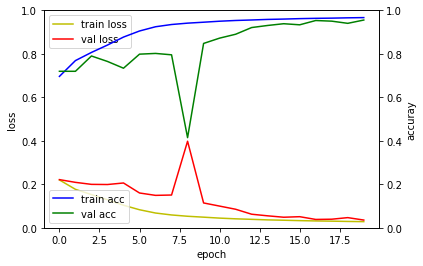

In [11]:
fig, loss_ax = plt.subplots  #  plt.subplots() 보충자료 참고

acc_ax = loss_ax.twinx()  # loss_ax.twinx() 보충자료 참고

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])   

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [12]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)  # unit8: 양의 정수 타입

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 25ms/step - loss: 0.0476 - accuracy: 0.9418


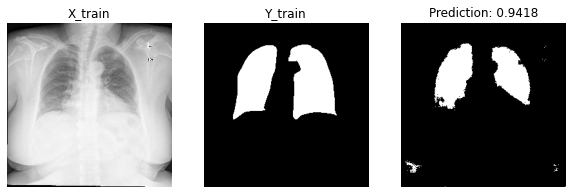

1/1 [==============================] - 0s 25ms/step - loss: 0.0288 - accuracy: 0.9613


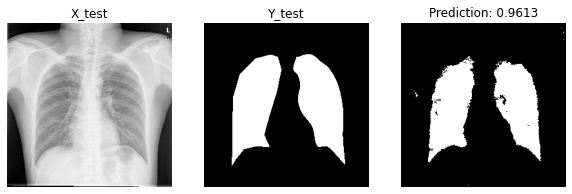

In [13]:
plotPredictions(model, train_x, train_y, test_x, test_y)

### 추가학습

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

import time

In [15]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



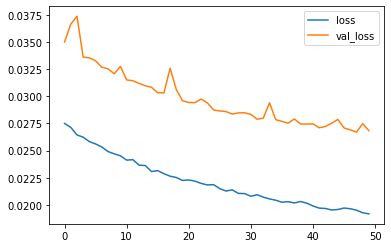

loss =  0.01917424239218235 , val_loss =  0.0268267635256052


In [16]:
plot_losses = PlotLosses()
model.fit(train_x, train_y, validation_split=0.2, epochs=50, batch_size=16, verbose=1,
          callbacks=[plot_losses])

1/1 [==============================] - 0s 24ms/step - loss: 0.0082 - accuracy: 0.9907


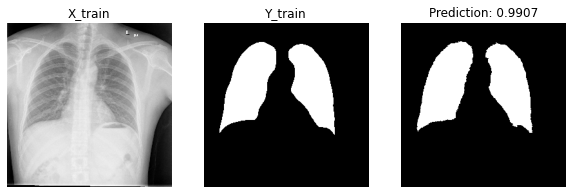

1/1 [==============================] - 0s 24ms/step - loss: 0.0212 - accuracy: 0.9738


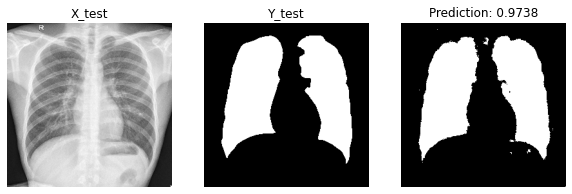

In [17]:
plotPredictions(model, train_x, train_y, test_x, test_y)

# 보충자료

## matplotlib.pyplot.imshow()
 회색조 이미지를 표시하려면 매개 변수cmap을'gray'로 설정.[출처](https://www.delftstack.com/ko/howto/matplotlib/matplotlib-display-image-in-grayscale/)
```
matplotlib.pyplot.imshow(X, 
                         cmap=None, 
                         norm=None, 
                         aspect=None, 
                         interpolation=None, 
                         alpha=None,
                         vmin=None,
                         vmax=None, 
                         origin=None, 
                         extent=None, 
                         shape=<deprecated parameter>, 
                         filternorm=1, 
                         filterrad=4.0, 
                         imlim=<deprecated parameter>, 
                         resample=None, 
                         url=None,
                         *,
                         data=None, 
                         **kwargs)
```



## plt.subplots()
```
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,1,50)
y1 = np.cos(4*np.pi*x)
y2 = np.cos(4*np.pi*x)*np.exp(-2*x)

fig,ax = plt.subplots()  # plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
ax.plot(x,y1,'r-*',lw=1)
ax.plot(x,y2,'b--',lw=1)
```
[출처](https://wikidocs.net/14604)

## Axes.twinx()
두개의 Y 축을 갖는 그래프는 Axes 객체를 x 축을 공유하도록 겹치면된다. 이때 사용되는 메쏘드가 Axes.twinx()이다. 
[출처](https://wikidocs.net/14605)

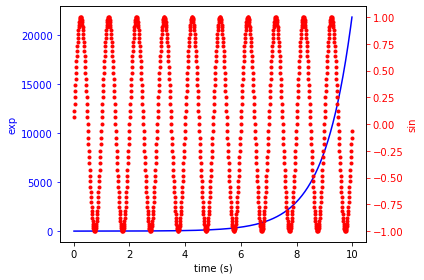

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = np.sin(2 * np.pi * t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

## os
운영체제와 관련된 각종 기능 제공
```
>>>import os 
>>>os.listdir()
[' 2flowers_classification_유현준.ipynb',
 '.ipynb_checkpoints',
 'anomaly_detection_using_autoencoder.ipynb',
 'autoencoder.ipynb',
 'base_result.png',
 'best_model.h5',
 'darknet',
 'darknet-master_Linux.zip',
 'darknet-master_WIN.zip',
 'data',
 'Day8-3_다양한 적용-1_얼굴 인식 실습.ipynb',
```
현재 위치 directory 목록을 보여줌
[출처](https://wikidocs.net/14682)
```

## os.path.splitext()
```
>>>import os

>>>file_path = 'C:/Users/Sim/Desktop/test/c1.txt'
>>>print(os.path.splitext(file_path))
>>>print("확장자: ", os.path.splitext(file_path)[1])

('C:/Users/Sim/Desktop/test/c1', '.txt')
확장자: .txt
```
[출처](https://bskyvision.com/1077)